In [1]:
# To initialise all the libraries you need for this notebook run the below code. 
# This is to be used when you are jumping through the document

import numpy as np
from numpy import sin,cos,exp, pi,log, log10, ceil
np.set_printoptions(precision=6,suppress=True,threshold=10)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,3)
import matplotlib.style as plt_style
plt_style.use("ggplot")
import matplotlib.dates as mdates

import csv
import datetime as dt
from statistics import mean

## <center> UNIVERSITY COLLEGE DUBLIN </center>
## <center> SCHOOL OF ELECTRICAL, ELECTRONIC & COMMUNICATIONS ENG. </center>
## <center> FINAL YEAR PROJECT</center>
### <center> James Carron </center>
## <center> EVs and the Grid </center>

Report by: 


<center>James Carron:  15333196

### Notes to self:
 - All values are in MW or MWh
 
### To Do
- Factor in the charging of the cars for regular use at night

In [2]:
def areaundercurve(data,hline,interval=0.25):
    total = 0.0
    for value in data:
        if value > hline:
            total += (value-hline)*interval
    return total

def areaabovecurve(data,hline,interval=0.25):
    total = 0.0
    for value in data:
        if value < hline:
            total += (hline-value)*interval
    return total

In [3]:
def importEirGridCSV(FILENAME, OUTPUT = False):
    with open(FILENAME, 'rb') as csvfile:
        EirGridCsv = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(EirGridCsv) #skip the header

        #remove extra quote marks and convert to str to int
        EirGridData = [[row[0].replace('"', ''), int(row[1])] for row in EirGridCsv]

    EirGridDate = [item[0] for item in EirGridData]    
    EirGridValue = [item[1] for item in EirGridData]  

    for i, value in enumerate(EirGridDate):
        EirGridDate[i] = dt.datetime.strptime(str(value), "%Y-%m-%d %H:%M:%S")
    
    if OUTPUT:
        print("Data from {} imported successfully".format(EirGridDate[0].date()))  
    
    return [EirGridDate,EirGridValue]

In [4]:
def EvalGridUsage(EirGridValue, OUTPUT = False):

    PeakDemand = max(EirGridValue)
    MinDemand = min(EirGridValue)
    UsageRange = max(EirGridValue)-min(EirGridValue)
    MeanUsage = mean(EirGridValue)
    TotalUsage = sum(EirGridValue)*0.25
    
    if OUTPUT:
        print("Peak Demand: \t{:.2f} MW".format(PeakDemand))
        print("Min Demand: \t{:.2f} MW".format(MinDemand))
        print("Range: \t{} MW".format(UsageRange))
        print("Mean: \t{:.2f} MW".format(MeanUsage))
        print("Total: \t{:.2f} GWh".format(TotalUsage/(1000.0)))
    
    return [PeakDemand, MinDemand, UsageRange, MeanUsage, TotalUsage]

In [5]:
def EvalBatteryStats(EirGridValue,MeanUsage,BattPercUsage,BatteryCapacity,NumUsers,DEBUG = True):
    CapacityAvailable = BattPercUsage*BatteryCapacity*NumUsers
    UsersNeeded = ceil(areaundercurve(EirGridValue,MeanUsage)/(BattPercUsage*BatteryCapacity))

    if DEBUG:
        print("Capacity Available: {:.0F} MWh".format(CapacityAvailable))
        print("Users Needed to smooth Peaks: {:,.0f}".format(UsersNeeded))
        
    return [CapacityAvailable, UsersNeeded]

def EvalBatterySmoothing(EirGridValue, CapacityAvailable, OUTPUT = False, LEEWAY = False):
    wbatterypeak = max(EirGridValue)
    while True:

        peakleeway = CapacityAvailable - areaundercurve(EirGridValue,wbatterypeak-1) #test next value
        if peakleeway < 0:
            peakleeway = CapacityAvailable - areaundercurve(EirGridValue,wbatterypeak)
            break
        else:
            wbatterypeak -= 1

    wbatterytrough = min(EirGridValue)
    while True:
        troughleeway = CapacityAvailable - areaabovecurve(EirGridValue,wbatterytrough+1) #test next value

        if troughleeway < 0:
            troughleeway = CapacityAvailable - areaabovecurve(EirGridValue,wbatterytrough)
            break
        else:
            wbatterytrough += 1

    wbatteryrange = wbatterypeak - wbatterytrough


    
    if OUTPUT:
        print("Peak   w/ Batteries: {}MW, \tLeeway: {} MWh".format(wbatterypeak, peakleeway))
        print("Trough w/ Batteries: {}MW, \tLeeway: {} MWh".format(wbatterytrough, troughleeway))
        print("Range: \t{} MW".format(wbatteryrange))
    
    if LEEWAY:
        return [wbatterypeak, wbatterytrough, wbatteryrange, peakleeway, troughleeway]    
    else:
        return [wbatterypeak, wbatterytrough, wbatteryrange]

def AdditionalBattStats(EirGridValue, wbatterypeak, wbatterytrough, NumUsers, UsageRange, OUTPUT = False):
    wbatteryrange = wbatterypeak - wbatterytrough
    PeakPowerDraw = (max(EirGridValue)-wbatterypeak)/NumUsers
    MaxChargingRate = (wbatterytrough-min(EirGridValue))/NumUsers
    Rangereduction = UsageRange - wbatteryrange
    Rangereductionperc = (UsageRange - wbatteryrange) / float(UsageRange)
    
    if OUTPUT:
        print("Peak Power draw per EV: {} kW".format(PeakPowerDraw*1000))
        print("Max Charge rate per EV: {} kW".format(MaxChargingRate*1000))
        print("Range Reduction: {:.2f}MW, {:.0%}%".format(Rangereduction,Rangereductionperc))
    
    return [PeakPowerDraw, MaxChargingRate, Rangereduction, Rangereductionperc]

In [34]:
def graphDemandCurve(EirGridDate, EirGridValue, MeanUsage, wbatterypeak, wbatterytrough):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(EirGridDate,EirGridValue,ls="-",label = "Demand")
    ax.axhline(MeanUsage, color="g",label = "Average")

    #Shading in battery effect

    # PEAK
    #ax.axhline(wbatterypeak, color="r",label = "hline")
    boolarray = list()
    for value in EirGridValue:
        if value > wbatterypeak:
            boolarray.append(True)
        else:
            boolarray.append(False)

    ax.fill_between(EirGridDate, wbatterypeak, EirGridValue, where= boolarray, interpolate=True,label="Discharging batteries")     

    # TROUGH
    #ax.axhline(wbatterytrough, color="b",label = "hline")
    boolarray = list()
    for value in EirGridValue:
        if value < wbatterytrough:
            boolarray.append(True)
        else:
            boolarray.append(False)

    ax.fill_between(EirGridDate, wbatterytrough, EirGridValue, where= boolarray, interpolate=True,label="Charging batteries")


    plt.title("Irish Energy Demand - {}".format(EirGridDate[0].date()))
    plt.ylabel("MW")
    plt.legend()

    #format the ticks
    myFmt = mdates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim(EirGridDate[0], EirGridDate[-1]+ dt.timedelta(minutes=15))
    plt.gcf().autofmt_xdate()

    plt.show()
    
    return True    

In [31]:
def EvalBatteryProject(FILENAME, BattPercUsage, BatteryCapacity, NumUsers, FUNC_OUTPUT = False):

    EirGridDate,EirGridValue = importEirGridCSV(FILENAME, True)

    PeakDemand, MinDemand, UsageRange, MeanUsage, TotalUsage = EvalGridUsage(EirGridValue, FUNC_OUTPUT)

    CapacityAvailable, UsersNeeded = EvalBatteryStats(EirGridValue, MeanUsage, BattPercUsage, BatteryCapacity, NumUsers, FUNC_OUTPUT)
    
    wbatterypeak, wbatterytrough, wbatteryrange = EvalBatterySmoothing(EirGridValue, CapacityAvailable, OUTPUT = FUNC_OUTPUT)
    
    PeakPowerDraw, MaxChargingRate, Rangereduction, Rangereductionperc = AdditionalBattStats(EirGridValue, wbatterypeak, wbatterytrough, NumUsers, UsageRange, OUTPUT = FUNC_OUTPUT)

    graphDemandCurve(EirGridDate, EirGridValue, MeanUsage, wbatterypeak, wbatterytrough)

    print("{} POWER DEMAND STATS:".format(EirGridDate[0].date()))   
    print("Peak Demand: \t{:.2f} MW".format(PeakDemand))
    print("Min Demand: \t{:.2f} MW".format(MinDemand))
    print("Mean: \t\t{:.2f} MW".format(MeanUsage))
    print("Range: \t{} MW".format(UsageRange))
    print("Total Usage: \t{:.2f} GWh".format(TotalUsage/(1000.0)))


    print("\nPROPOSED PLAN:")
    print("{:,.0f} EV's w/ {:.0f} kW packs connected to the grid, using {:.0%} of their capacity".format(NumUsers, BatteryCapacity*1000, BattPercUsage))
    print("Available Capacity: \t{:.0F} MWh".format(CapacityAvailable))


    print("\nOUTCOME")
    print("Peak Usage: \t{}MW".format(wbatterypeak))
    print("Min Usage: \t{}MW".format(wbatterytrough))
    print("Range: \t{} MW \tReduced by: {:.2f}MW, {:.0%}".format(wbatteryrange, Rangereduction,Rangereductionperc))

    print("Peak Power draw per EV: {} kW".format(PeakPowerDraw*1000))
    print("Max Charge rate per EV: {} kW".format(MaxChargingRate*1000))

    print("Users Needed to smooth Peaks: {:,.0f}".format(UsersNeeded))

# Main

Battery Capacity stats:
https://en.wikipedia.org/wiki/Electric_vehicle_battery

From this I assume a 50kW battery pack as standard

There are over 2.5million cars on the irish roads
https://www.independent.ie/life/motoring/car-news/number-of-private-cars-on-our-roads-hits-two-million-34460268.html

Data from 2018-06-25 imported successfully


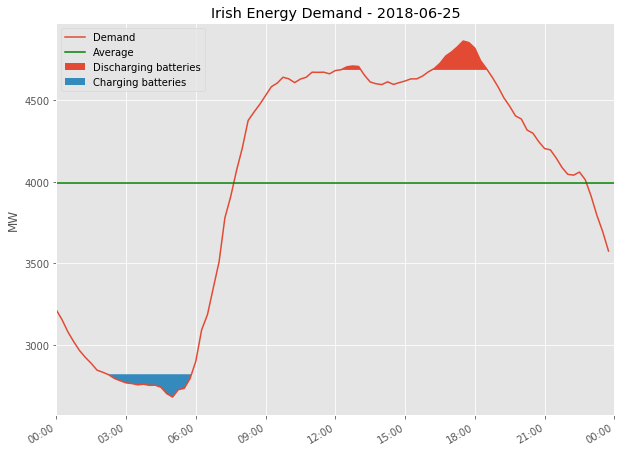

2018-06-25 POWER DEMAND STATS:
Peak Demand: 	4862.00 MW
Min Demand: 	2680.00 MW
Mean: 		3993.43 MW
Range: 	2182 MW
Total Usage: 	95.84 GWh

PROPOSED PLAN:
20,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
Available Capacity: 	250 MWh

OUTCOME
Peak Usage: 	4685MW
Min Usage: 	2820MW
Range: 	1865 MW 	Reduced by: 317.00MW, 15%
Peak Power draw per EV: 8.85 kW
Max Charge rate per EV: 7.0 kW
Users Needed to smooth Peaks: 656,879


In [35]:
BattPercUsage = 0.25
BatteryCapacity = 50*(10**-3)
NumUsers = 20000.0

#FILENAME = 'EirGridData050118.csv'
#FILENAME = 'EirGridData180218.csv'
FILENAME = "EirGridData250618.csv"

FUNC_OUTPUT = False

EvalBatteryProject(FILENAME, BattPercUsage, BatteryCapacity, NumUsers, FUNC_OUTPUT = False)